In [4]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
import os
import warnings
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import visualkeras
import cv2

from keras import Sequential, Model
from keras.layers import Dense, Conv2D, Reshape, UpSampling2D, BatchNormalization, Activation, Input, LeakyReLU, ZeroPadding2D, Dropout, Flatten, Conv2DTranspose, Normalization, Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2, l1_l2
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.initializers import RandomNormal


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable TF Warnings
tf.get_logger().setLevel('INFO')
warnings.filterwarnings("ignore")
seed=np.random.seed(69)
sns.set(style='darkgrid', palette='deep')

In [6]:
## Change accordingly
# Yong Dir
# df = pd.read_csv('C:/Users/yongj/OneDrive - Singapore Polytechnic/SP DAAA-Y2/DELE/CA2/GAN/emnist-letters-train.csv')
# df = pd.read_csv('C:/Users/p2342377/Downloads/emnist-letters-train.csv')

# Jovan Dir
df = pd.read_csv('emnist-letters-train.csv')

In [7]:
y1 = np.array(df.iloc[:,0].values)
X_train = np.array(df.iloc[:,1:].values)
X_train = np.array([np.rot90(np.flipud(sample.reshape(28, 28, 1)), k=3) for sample in X_train])
print(y1.shape)
print(X_train.shape)

(99039,)
(99039, 28, 28, 1)


In [8]:
pd.Series(y1).value_counts()

-1     10240
 25     3453
 11     3438
 5      3437
 24     3437
 20     3436
 17     3435
 16     3430
 9      3428
 26     3427
 8      3424
 22     3422
 23     3422
 18     3419
 21     3419
 3      3419
 12     3415
 15     3408
 10     3402
 13     3402
 4      3398
 1      3396
 2      3396
 6      3394
 19     3392
 7      3385
 14     3365
Name: count, dtype: int64

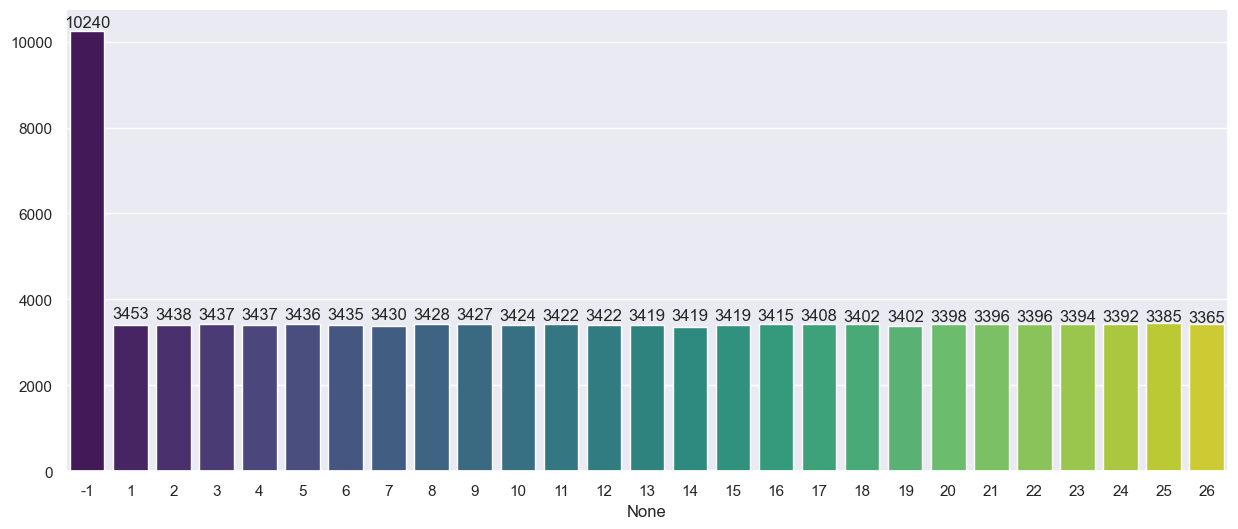

In [9]:
# Bar plot of each letter
plt.figure(figsize=(15, 6))
values = pd.Series(y1).value_counts()
sns.barplot(x=values.index, y=values.values, palette='viridis')
# Add value on top of the bar
for i, value in enumerate(values.values):
    plt.text(i, value+100, f'{value}', ha='center')

In [10]:
#Drop y1
y_train = y1[y1!=-1]
x_train = X_train[y1!=-1]

In [11]:
print(y_train.shape)
print(x_train.shape)

(88799,)
(88799, 28, 28, 1)


Max Count: 3453
Min Count: 3365


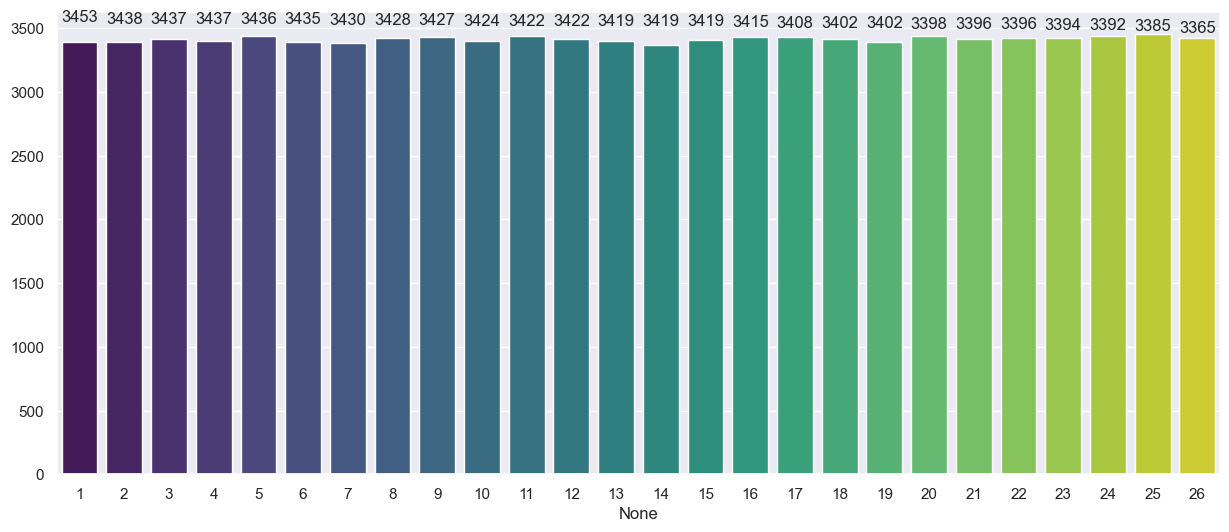

In [12]:
# Bar plot of each letter
plt.figure(figsize=(15, 6))
values = pd.Series(y_train).value_counts()
sns.barplot(x=values.index, y=values.values, palette='viridis')
# Add value on top of the bar
for i, value in enumerate(values.values):
    plt.text(i, value+100, f'{value}', ha='center')
print(f"Max Count: {max(values)}")
print(f"Min Count: {min(values)}")

In [13]:
number_to_letter = {}
for i in range(1, 27):
    number_to_letter[i] = chr(ord('a') + i - 1)
number_to_letter[-1] = 'nothing'

#### Looking at the Images

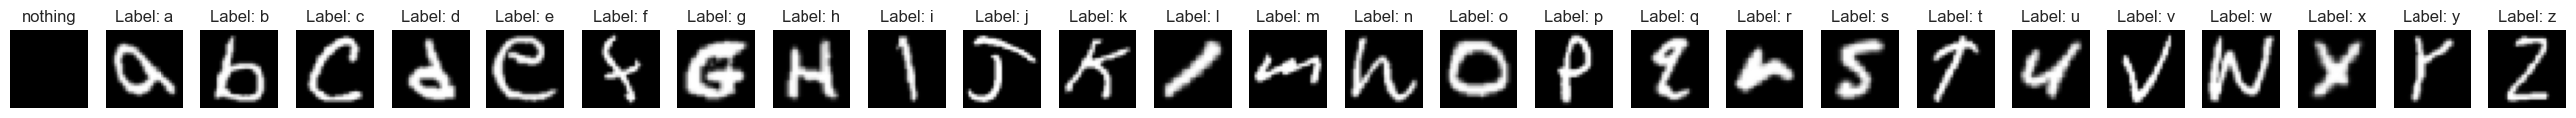

In [14]:
# SHow an image from each classes
fig,axes = plt.subplots(1,27,figsize=(26,26))
for i,ax in enumerate(axes.flat):
    if i == 0:
        ax.set_title(f'nothing')
        ax.imshow(X_train[y1==-1][0], cmap='gray')
    else:
        ax.set_title(f'Label: {number_to_letter[i]}')
        ax.imshow(X_train[y1==i][0], cmap='gray')
    ax.axis('off')  # Turn off the axis

plt.tight_layout()

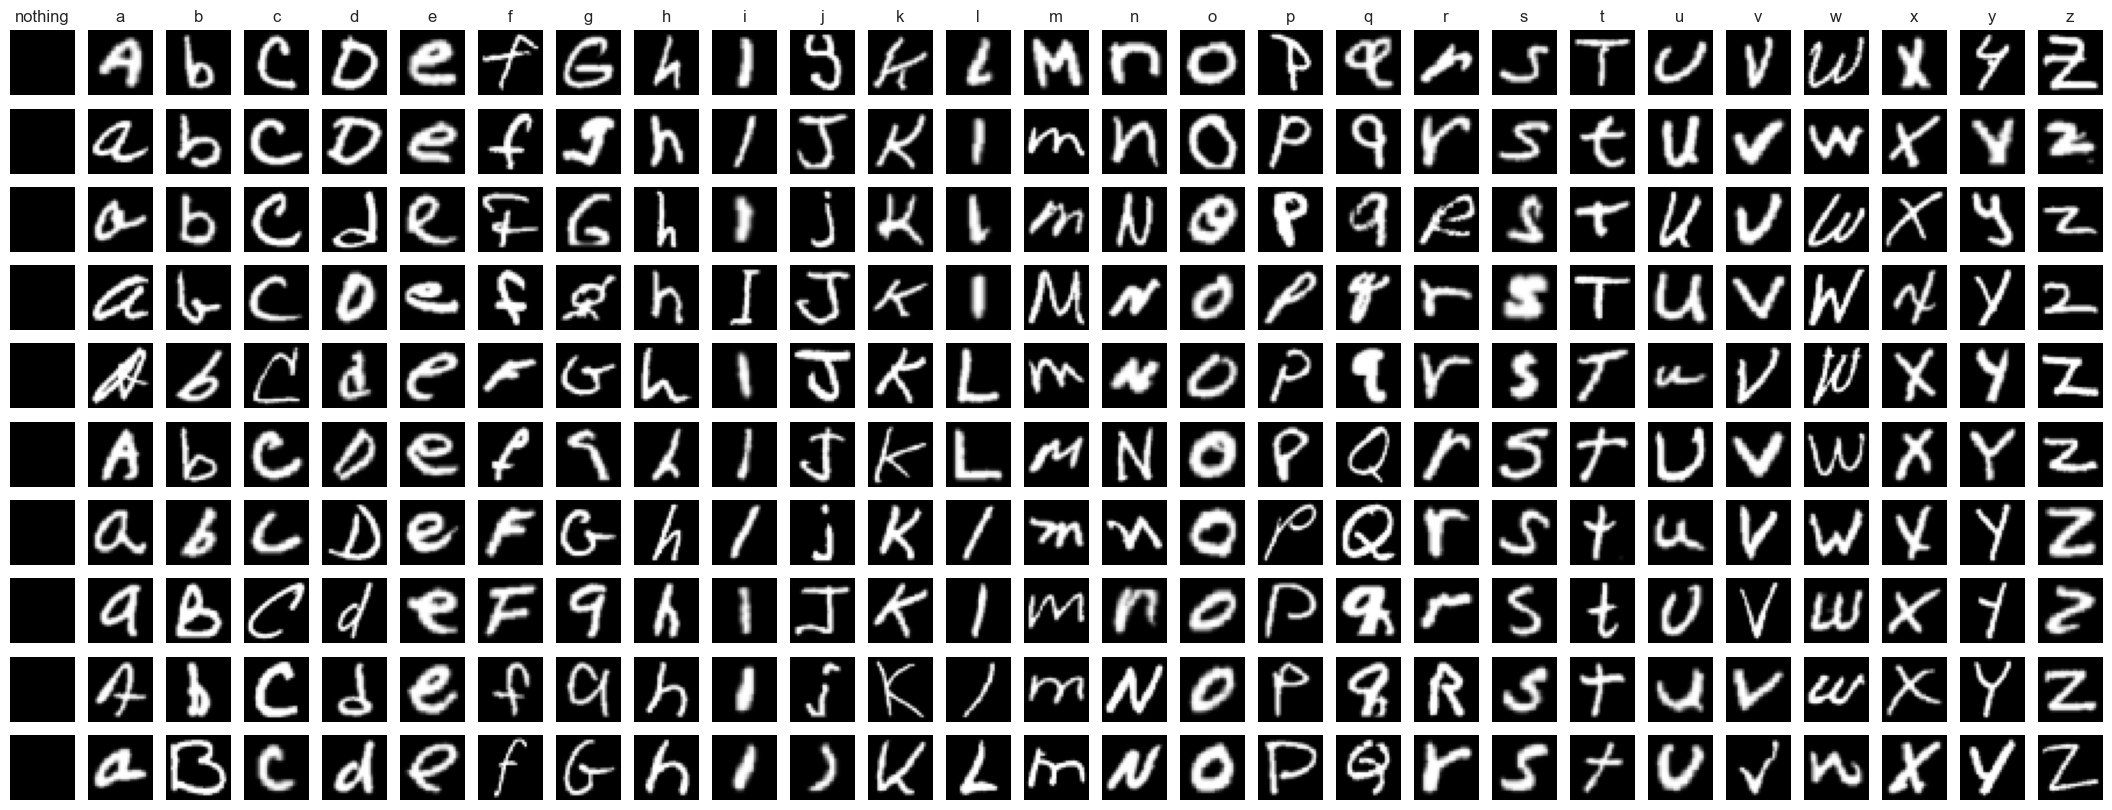

In [15]:
# Show 10 random image from each classes
fig,axes = plt.subplots(10,27,figsize=(27,10))
for i,ax in enumerate(axes.flat):
    if i%27 == 0:
        ax.imshow(X_train[y1 == -1][np.random.choice(len(X_train[y1 == -1]))], cmap='gray')
    else:
        ax.imshow(X_train[y1==i%27][np.random.choice(len(X_train[y1 == i%27]))], cmap='gray')
    ax.axis('off')  # Turn off the axis


# Add title to first row
axes[0,0].set_title(f'{number_to_letter[-1]}')
for i in range(1,27):
    axes[0,i].set_title(f'{number_to_letter[i%27]}')

##### <u>Observations</u>

1. **Variation in Class**:
   - The classes consist of both upper and lower case letters.

2. **Variation in handwriting**:
   - Handwriting for letters varies in slant, thickness, and style.

3. **Distinctive Classes**:
   - Some letters, such as 'c' and 'C', are difficult to distinguish as upper or lower case due to similar writing styles.
   - Other letters such as 'd' and 'D' are written in very distinct ways, making it easier to differentiate between their upper and lower case forms.


#### Getting the Average Imaging

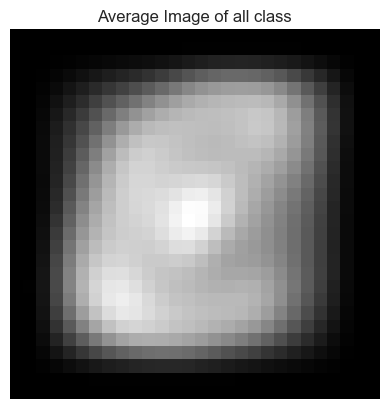

In [16]:
# OVerall average image
plt.title('Average Image of all class')
plt.imshow(np.mean(X_train, axis=0), cmap='gray')
plt.axis('off')  # Turn off the axis
plt.show()

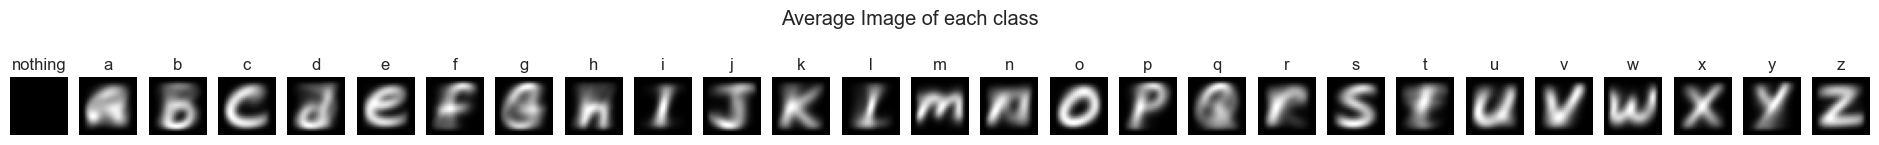

In [17]:
# Get average image of each classes
average_images = []
for i in range(27):
    if i == 0:
        i = -1
    average_images.append(np.mean(X_train[y1==i], axis=0))

# Show average image of each classes
fig,axes = plt.subplots(1,27,figsize=(24,2))   

for i,ax in enumerate(axes.flat):
    ax.imshow(average_images[i], cmap='gray')
    ax.imshow(average_images[i], cmap='gray')
    ax.axis('off')  # Turn off the axis
    if i == 0:
        i = -1
    ax.set_title(f'{number_to_letter[i]}')

fig.suptitle('Average Image of each class')
plt.show()

##### <u>Observations</u>

- Letters such as 'x', 'b', 'c', and 'e' are well-defined and easily distinguishable.
- Letters such as 'g' and 'q' have a more blurred appearance, which is expected as the upper and lower case are more distinct.
- The model may have a harder time producing clear images of letters which have distinct looking upper case from the lower case letters

#### Pixel Distribution

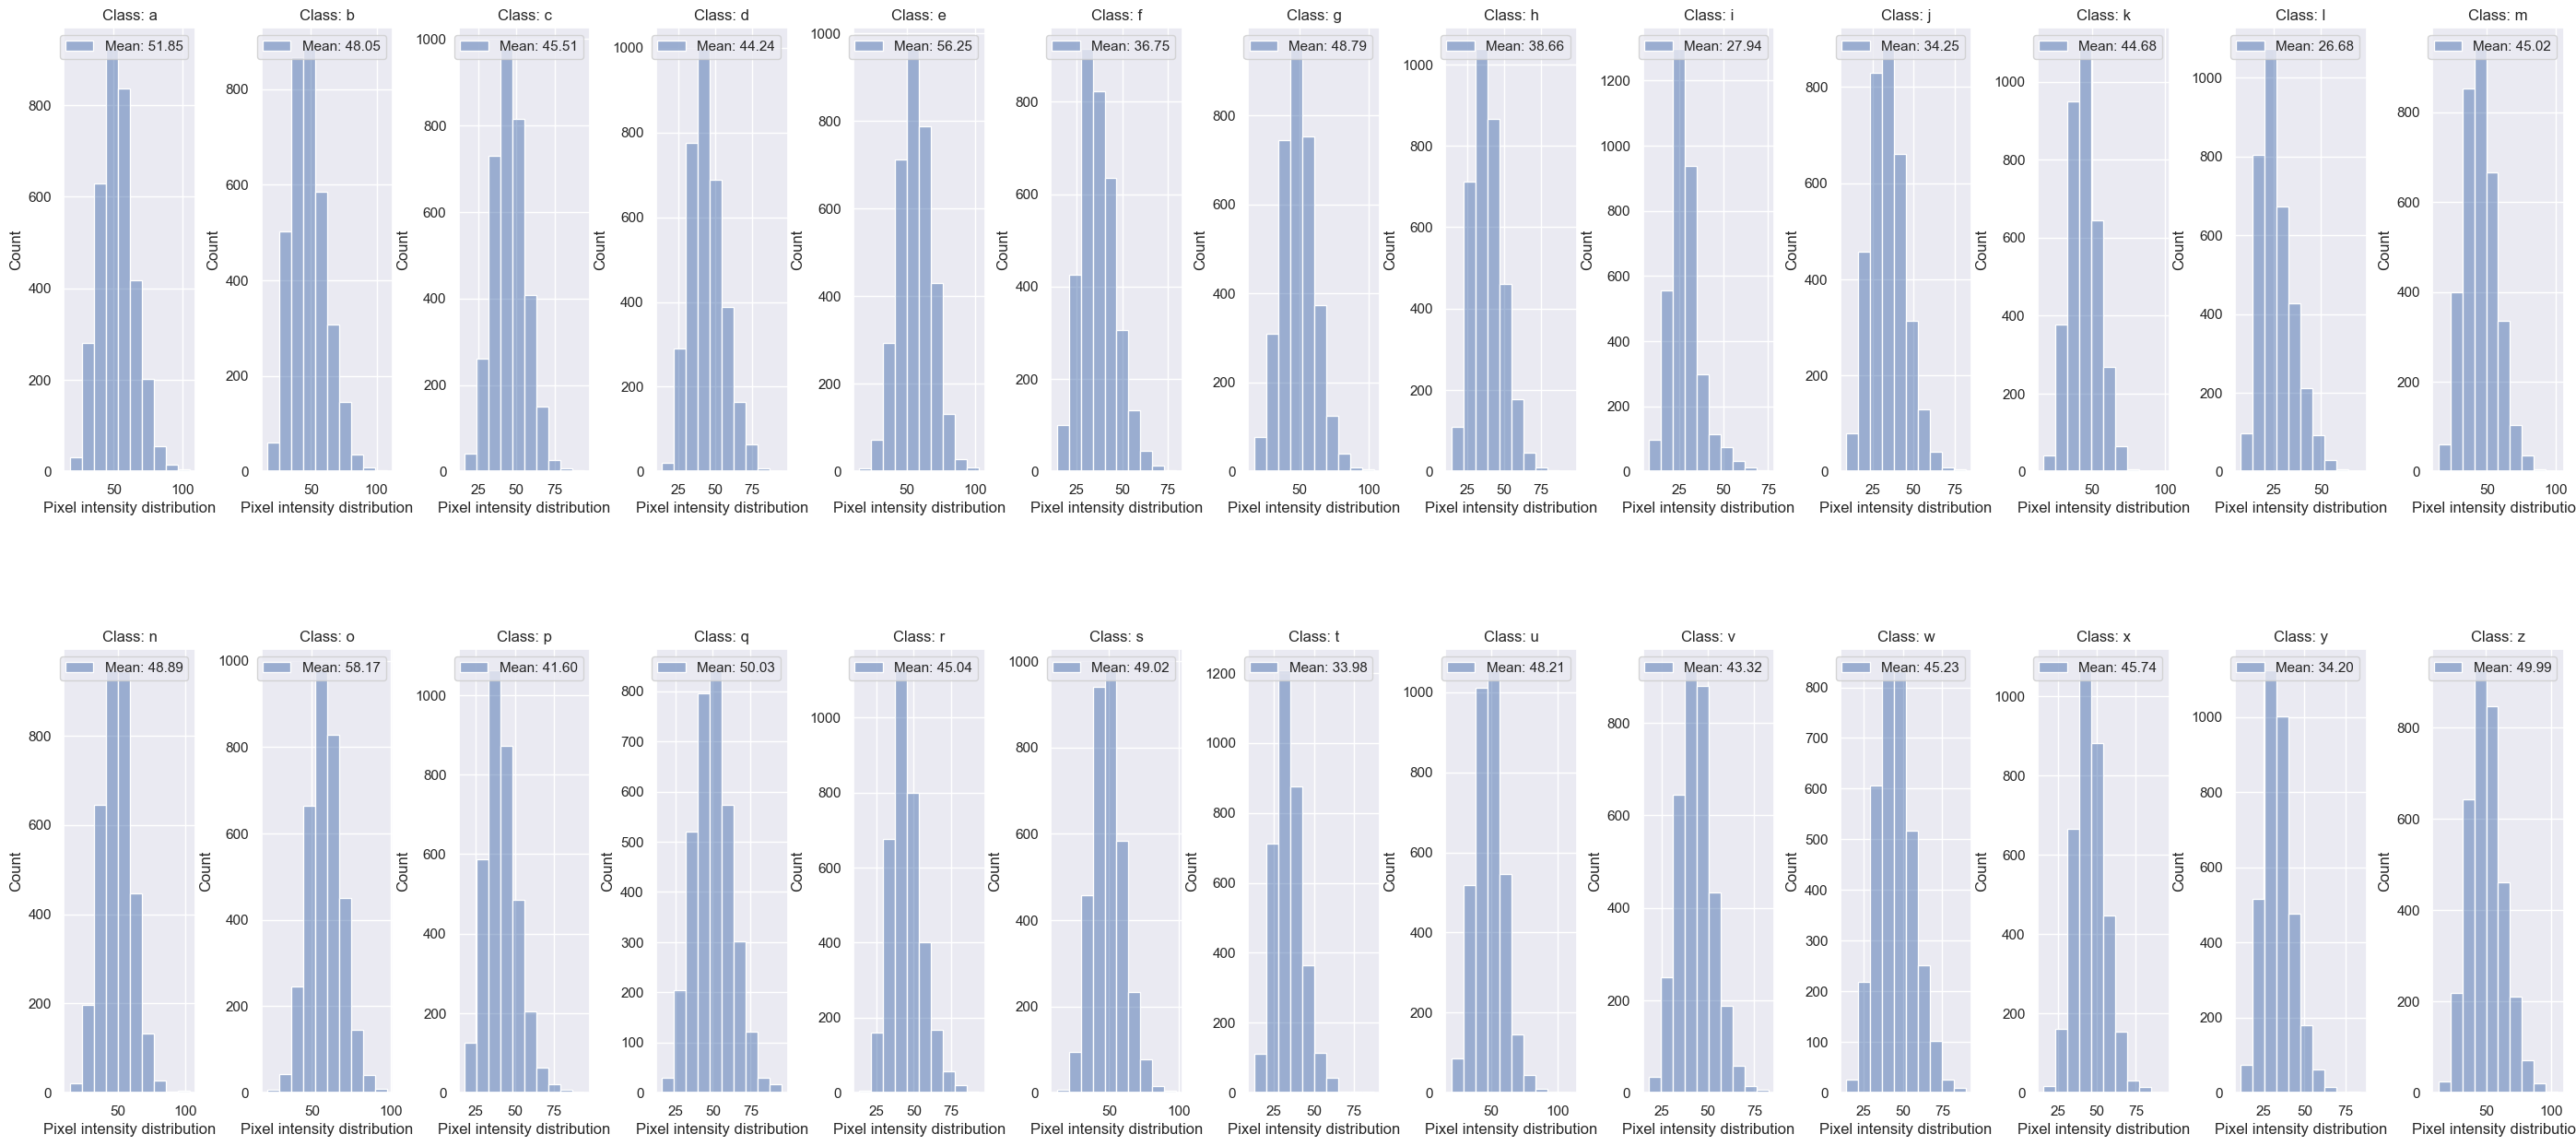

In [18]:
def plot_pixel_intensity_distribution(data, label, ax):
    brighness = np.mean(data, axis=(1, 2))
    sns.histplot(brighness, bins=10, ax=ax)
    ax.set_xlabel("Pixel intensity distribution")
    ax.set_title(f"Class: {label}")
    ax.legend([f"Mean: {np.mean(brighness):.2f}"])
    return ax

fig, axes = plt.subplots(2, 13, figsize=(35, 15))
plt.subplots_adjust(hspace=0.4, wspace=0.5)
for i in range(26):
    row = i // 13
    col = i % 13
    ax = plot_pixel_intensity_distribution(X_train[y1 == i+1], number_to_letter[i+1], axes[row, col])

plt.show()

<hr>

### Data Preprocessing

<hr>

In [19]:
rescale_layer = Rescaling((1./255), input_shape=(28, 28, 1))
X_rescale = rescale_layer(X_train)

normalization_layer = Normalization(input_shape=(28, 28, 1))
normalization_layer.adapt(X_rescale)
x_train_normalized = normalization_layer(X_rescale)

In [20]:
difference = cv2.subtract(X_rescale[0].numpy().squeeze(), x_train_normalized[0].numpy().squeeze())

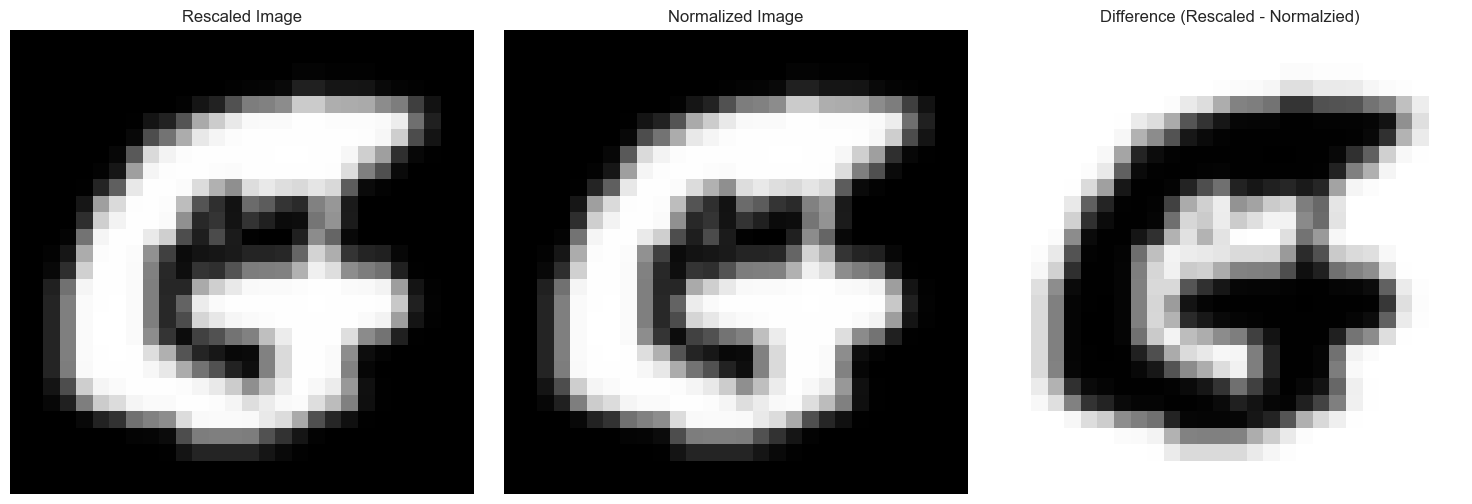

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)
ax[0].imshow(X_rescale[0], cmap='gray')
ax[0].set_title("Rescaled Image")
ax[0].axis('off')
ax[1].imshow(x_train_normalized[0].numpy().squeeze(), cmap='gray')
ax[1].set_title("Normalized Image")
ax[1].axis('off')
ax[2].imshow(difference, cmap='gray')
ax[2].set_title("Difference (Rescaled - Normalzied)")
ax[2].axis('off')
plt.show()

In [22]:
# datagen = ImageDataGenerator(
#     rotation_range=10,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.2,
#     fill_mode="nearest",
# )

In [23]:
# target = 3453
# augmented_images = []
# augmented_labels = []
# labels, counts = np.unique(y1, return_counts=True)
# print(counts)
# for i in list(range(27)):
#     if counts[i] < target:
#         class_idx = np.where(y1 == i)[0]
#         class_images = tf.gather(X_train, tf.convert_to_tensor(class_idx)) # Get the images
#         difference = target - counts[i]
#         for j in range(difference):
#             random_index = np.random.randint(0, len(class_idx))
#             if len(augmented_labels) == 0:
#                 random_class_idx= class_idx[random_index]
#             image_np = class_images[random_index].numpy().reshape((1, 28, 28, 1))
#             aug_image = datagen.flow(image_np, batch_size=1)
#             augmented_images.append(next(aug_image)[0].astype('uint8'))
#             augmented_labels.append(i)


In [24]:
# fig, ax = plt.subplots(1,2, figsize=(6, 3), tight_layout=True)
# ax[0].imshow(X_train[random_class_idx], cmap='gray')
# ax[0].axis('off')
# ax[0].set_title('Before Augmentation')
# ax[1].imshow(augmented_images[0], cmap='gray')
# ax[1].set_title('After Augmentation')
# ax[1].axis('off')

# plt.suptitle('Comparison Before & After')
# plt.show()

In [25]:
print(x_train.shape)
print(y_train.shape)

(88799, 28, 28, 1)
(88799,)


In [26]:
# X_train_augmented = np.array(augmented_images)  # Convert augmented_images to numpy array
# X_train_concatenated = np.concatenate((X_train, X_train_augmented.reshape(X_train_augmented.shape[:-1])))  # Concatenate along the first axis

# y_train_concatenated = np.concatenate((y1, augmented_labels))  # Concatenate labels

# # Shuffle the concatenated dataset
# shuffle_indices = np.random.permutation(len(X_train_concatenated))
# X_train_concatenated = X_train_concatenated[shuffle_indices]
# y_train_concatenated = y_train_concatenated[shuffle_indices]


In [27]:
# labels, counts = np.unique(y_train_concatenated, return_counts=True, )
# plt.figure(figsize=(12, 6))
# plt.bar(labels, counts)
# for i in range(len(labels)):
#     plt.text(labels[i], counts[i], str(counts[i]), ha='center', va='bottom')
# plt.xticks(rotation=90)
# plt.title('Train Class After Aug Distribution')
# plt.show()

<hr>

### Building Baseline Model
<hr>

1. GAN Model 1 (DCGAN)
2. GAN Model 2 (cGAN)
3. GAN Model 3 (WGAN)
4. GAN Model 4 (ACGAN)
5. GAN Model 5 (BIGGAN/StyleGAN/PaperGAN) [Optional]

In [41]:
x_train

array([[[[ 0],
         [ 0],
         [ 0],
         ...,
         [ 0],
         [ 0],
         [ 0]],

        [[ 0],
         [ 0],
         [ 0],
         ...,
         [ 0],
         [ 0],
         [ 0]],

        [[ 0],
         [ 0],
         [ 0],
         ...,
         [ 0],
         [ 0],
         [ 0]],

        ...,

        [[ 0],
         [ 0],
         [ 0],
         ...,
         [ 0],
         [ 0],
         [ 0]],

        [[ 0],
         [ 0],
         [ 0],
         ...,
         [ 0],
         [ 0],
         [ 0]],

        [[ 0],
         [ 0],
         [ 0],
         ...,
         [ 0],
         [ 0],
         [ 0]]],


       [[[ 0],
         [ 0],
         [ 0],
         ...,
         [ 0],
         [ 0],
         [ 0]],

        [[ 0],
         [ 0],
         [ 0],
         ...,
         [ 0],
         [ 0],
         [ 0]],

        [[ 0],
         [ 0],
         [ 0],
         ...,
         [ 0],
         [ 0],
         [ 0]],

        ...,

        [[ 0],
 

In [42]:
y_train

array([ 7, 16, 15, ..., 18, 24, 19], dtype=int64)

https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit#wrapping_up_an_end-to-end_gan_example

In [28]:
class DCGAN:

    def build_generator(self):
        model = Sequential(name="Generator")
        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(
            Conv2D(self.channels, kernel_size=7, padding="same", activation="sigmoid")
        )
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential(name="Discriminator")
        model.add(
            Conv2D(
                128,
                kernel_size=3,
                strides=2,
                input_shape=self.img_shape,
                padding="same",
            )
        )
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(1, activation="sigmoid"))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)

    def __init__(self, rows, cols, channels, z=100):
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z
        optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        self.kl_divergence = keras.metrics.KLDivergence(name="kl_divergence")

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(
            loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"]
        )

        self.generator = self.build_generator()
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        self.discriminator.trainable = False
        valid = self.discriminator(img)
        self.combined = Model(z, valid)
        self.combined.compile(loss="binary_crossentropy", optimizer=optimizer)

    def train(self, train_images, epochs, batch_size=128, save_interval=50):
        X_train = train_images
        X_train = X_train / 255
        X_train = np.expand_dims(X_train, axis=3)
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            g_loss = self.combined.train_on_batch(noise, valid)

            kl_loss = self.kl_divergence(imgs, gen_imgs)
            print(
                "%d [D loss: %f, acc.: %.2f%%] [G loss: %f] [KL div: %f]"
                % (epoch, d_loss[0], 100 * d_loss[1], g_loss, kl_loss)
            )

            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap="gray")
                axs[i, j].axis("off")
                cnt += 1
        os.makedirs(
            "C:/Users/Jovan Luong/Documents/DELE/GAN/DCGAN/train_data/", exist_ok=True
        )
        fig.savefig(
            "C:/Users/Jovan Luong/Documents/DELE/GAN/DCGAN/train_data/dcgan_mnist_{:d}.png".format(
                epoch
            )
        )
        plt.close()

In [29]:
dcgan = DCGAN(28,28,1)
dcgan.train(train_images=x_train,epochs=5000, batch_size=256, save_interval=50)

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 128)       0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)            

In [51]:
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, LeakyReLU
from keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras


class CGAN:
    def build_generator(self):
        model = Sequential(name="Generator")

        model.add(
            Dense(
                128 * 7 * 7,
                activation="relu",
                input_dim=self.latent_dim + self.num_classes,
            )
        )
        model.add(Reshape((7, 7, 128)))

        model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        model.add(
            Conv2D(self.channels, kernel_size=7, padding="same", activation="tanh")
        )
        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(self.num_classes,), dtype="float32")
        model_input = Concatenate()([noise, label])

        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):
        model = Sequential(name="Discriminator")

        model.add(
            Conv2D(
                128,
                kernel_size=3,
                strides=2,
                input_shape=(self.img_rows, self.img_cols, self.channels + 1),
                padding="same",
            )
        )
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))

        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))

        model.add(Flatten())
        model.add(Dense(1, activation="sigmoid"))
        model.summary()

        img = Input(shape=self.img_shape)
        label = Input(shape=(self.num_classes,), dtype="float32")
        label_embedding = Dense(np.prod(self.img_shape))(label)
        label_embedding = Reshape(self.img_shape)(label_embedding)

        model_input = Concatenate(axis=-1)([img, label_embedding])

        validity = model(model_input)

        return Model([img, label], validity)

    def __init__(self, rows, cols, channels, num_classes, z=100):
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z
        self.num_classes = num_classes

        optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        self.kl_divergence = keras.metrics.KLDivergence(name="kl_divergence")

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(
            loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"]
        )

        self.generator = self.build_generator()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(self.num_classes,))
        img = self.generator([noise, label])

        self.discriminator.trainable = False
        valid = self.discriminator([img, label])

        self.combined = Model([noise, label], valid)
        self.combined.compile(loss="binary_crossentropy", optimizer=optimizer)

    def train(
        self, train_images, train_labels, epochs, batch_size=128, save_interval=50
    ):
        X_train = train_images
        X_train = X_train / 255.0
        X_train = np.expand_dims(X_train, axis=3)

        # Adjust train_labels to be zero-indexed
        train_labels_zero_indexed = train_labels - 1
        y_train = keras.utils.to_categorical(
            train_labels_zero_indexed, num_classes=self.num_classes
        )

        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict([noise, labels])

            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            g_loss = self.combined.train_on_batch([noise, labels], valid)

            kl_loss = self.kl_divergence(imgs, gen_imgs)
            print(
                "%d [D loss: %f, acc.: %.2f%%] [G loss: %f] [KL div: %f]"
                % (epoch, d_loss[0], 100 * d_loss[1], g_loss, kl_loss)
            )

            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))

        # Ensure sampled_labels has the same number of samples as noise
        sampled_labels = np.tile(
            np.arange(0, self.num_classes), r * c // self.num_classes + 1
        )[: r * c]
        sampled_labels = keras.utils.to_categorical(
            sampled_labels, num_classes=self.num_classes
        )

        gen_imgs = self.generator.predict([noise, sampled_labels])

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap="gray")
                axs[i, j].axis("off")
                cnt += 1
        os.makedirs(
            "C:/Users/Jovan Luong/Documents/DELE/GAN/cGAN/train_data/", exist_ok=True
        )
        fig.savefig(
            "C:/Users/Jovan Luong/Documents/DELE/GAN/cGAN/train_data/cgan_mnist_{:d}.png".format(
                epoch
            )
        )
        plt.close()


# Example usage
num_classes = len(np.unique(y_train))
cgan = CGAN(28, 28, 1, num_classes)
cgan.train(
    train_images=x_train,
    train_labels=y_train,
    epochs=5000,
    batch_size=256,
    save_interval=50,
)

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 14, 14, 128)       2432      
                                                                 
 leaky_re_lu_54 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 dropout_28 (Dropout)        (None, 14, 14, 128)       0         
                                                                 
 conv2d_42 (Conv2D)          (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_55 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_29 (Dropout)        (None, 7, 7, 128)         0         
                                                                 
 flatten_14 (Flatten)        (None, 6272)            

In [ ]:
class wGAN:
    